In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null, forward_simulation

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'qj'
category = 'synthetic'
eccentricity = 'periphery'
movie_id = 5
diameter = 36; # 6, 24, 36
dat_movie_name = 'PRAIRIE'   # movie name as in the data file name
stim_movie_name = 'prairie1' # movie name as in the stimulus file name
n_bootstraps = 1

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
is_natural = True if category == 'natural' else False
    
# n_dim = n_frames - 1
n_dim = 5
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_dim=n_dim, n_starts=10, n_iter=10000, n_frames=n_frames, is_natural=is_natural, version=1, disp=False)

Current loss: 330.19122994691133
Loss updated
Iteration 1 | Loss: 330.19122994691133
Current loss: 317.5583880506456
Loss updated
Iteration 2 | Loss: 317.5583880506456
Current loss: 322.13393400609493
Iteration 3 | Loss: 322.13393400609493
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 4 | Loss: 354.2513559907675
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 5 | Loss: 339.31676561012864
Current loss: 314.9714207164943
Loss updated
Iteration 6 | Loss: 314.9714207164943
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 7 | Loss: 362.00595793128014
Current loss: 328.128387182951
Iteration 8 | Loss: 328.128387182951
Current loss: 349.8179984167218
Iteration 9 | Loss: 349.8179984167218
Current loss: 314.1318123117089
Loss updated
Iteration 10 | Loss: 314.1318123117089


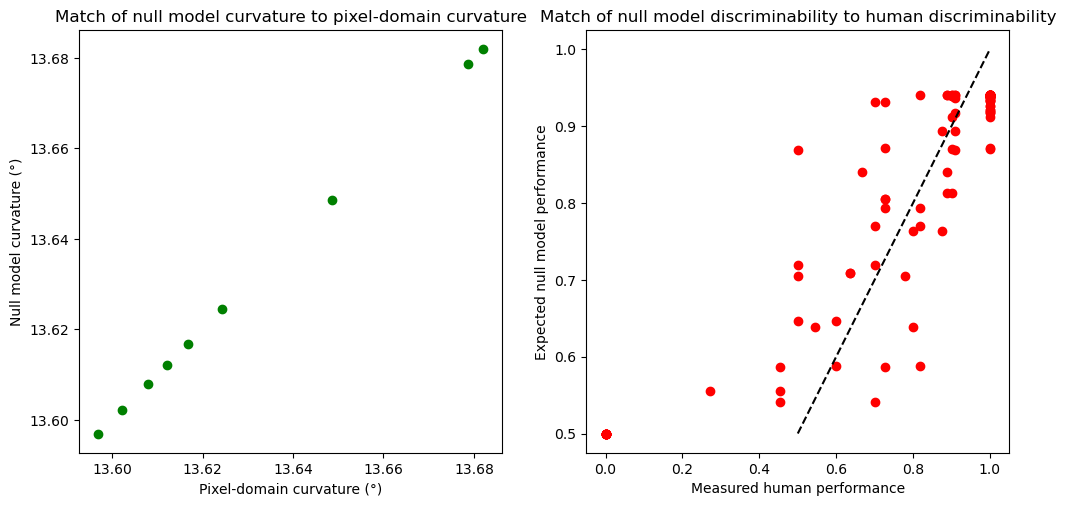

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Measured human performance')
axs[1].set_ylabel('Expected null model performance')
axs[1].set_box_aspect(1)

### Synthesize data from null model observer

In [18]:
# n_reps = int(np.max(n_total_obs))
n_reps = 10
prob_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.squeeze(), n_reps, var = 1.0)

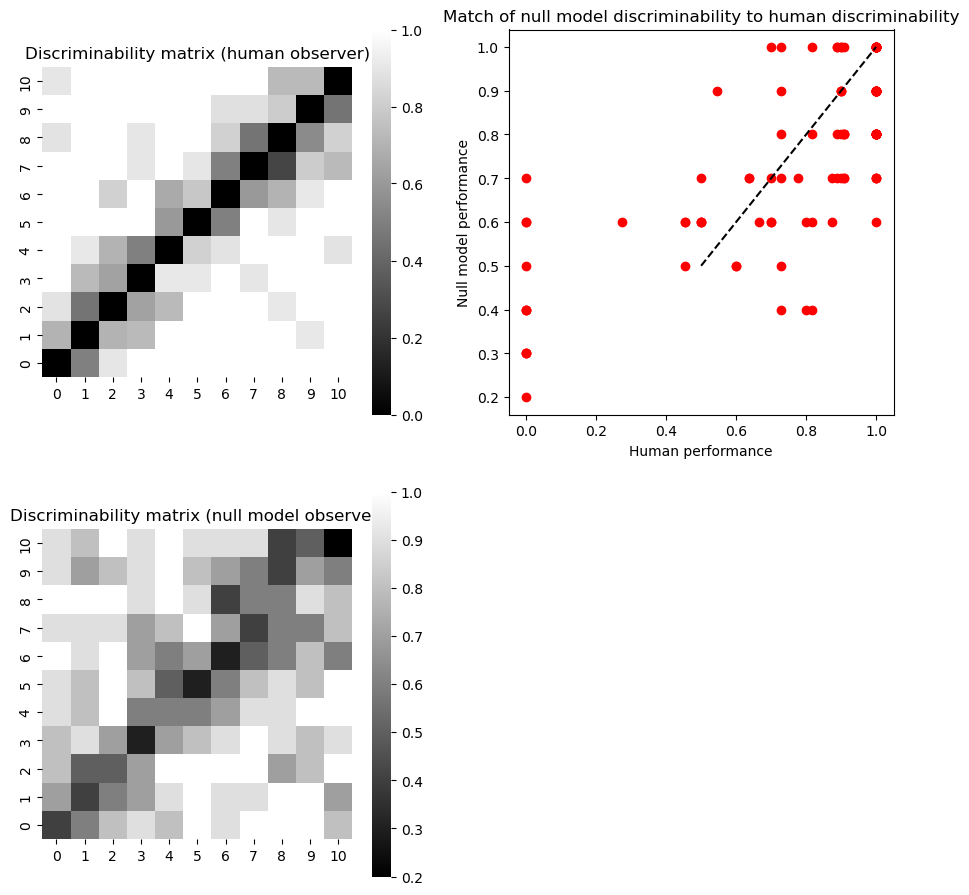

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

sns.heatmap(prob_corr_null_sim, ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[0, 1].plot(prob_corr_human.flatten(), prob_corr_null_sim.flatten(), 'ro')
axs[0, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 1].set_title('Match of null model discriminability to human discriminability')
axs[0, 1].set_xlabel('Human performance')
axs[0, 1].set_ylabel('Null model performance')
axs[0, 1].set_box_aspect(1)

axs[1, 1].set_axis_off()

### Run optimization on simulated data from null model

In [20]:
n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=80000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, c_post_null, d_post_null, l_post_null, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 432.51211558282375
Loss updated
Iteration 1 | Loss: 432.51211558282375
Current loss: 412.6686633527279
Loss updated
Iteration 2 | Loss: 412.6686633527279
Current loss: 397.6201361194253
Loss updated
Iteration 3 | Loss: 397.6201361194253
Current loss: 406.78385673835874
Iteration 4 | Loss: 406.78385673835874
Current loss: 403.5335386991501
Iteration 5 | Loss: 403.5335386991501
Current loss: 412.1430231630802
Iteration 6 | Loss: 412.1430231630802
Current loss: 394.2185150682926
Loss updated
Iteration 7 | Loss: 394.2185150682926
Current loss: 409.76109302416444
Iteration 8 | Loss: 409.76109302416444
Current loss: 428.7306441143155
Iteration 9 | Loss: 428.7306441143155
Current loss: 400.22696091234684
Iteration 10 | Loss: 400.22696091234684
Epoch: 0, Loss: 805.7091098975967
Epoch: 250, Loss: 706.3183142953862
Epoch: 500, Loss: 649.6008262162277
Epoch: 750, Loss: 609.8505557978027
Epoch: 1000, Loss: 581.996115434199

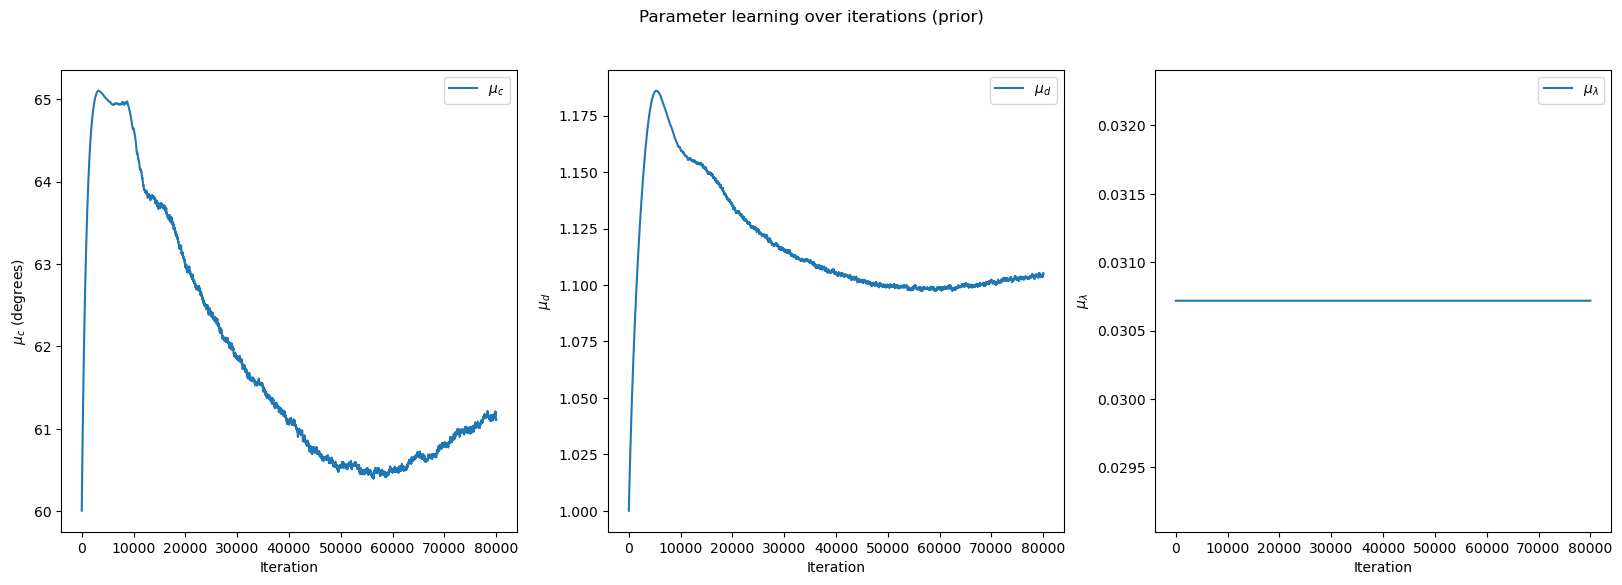

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior_null, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior_null, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior_null, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

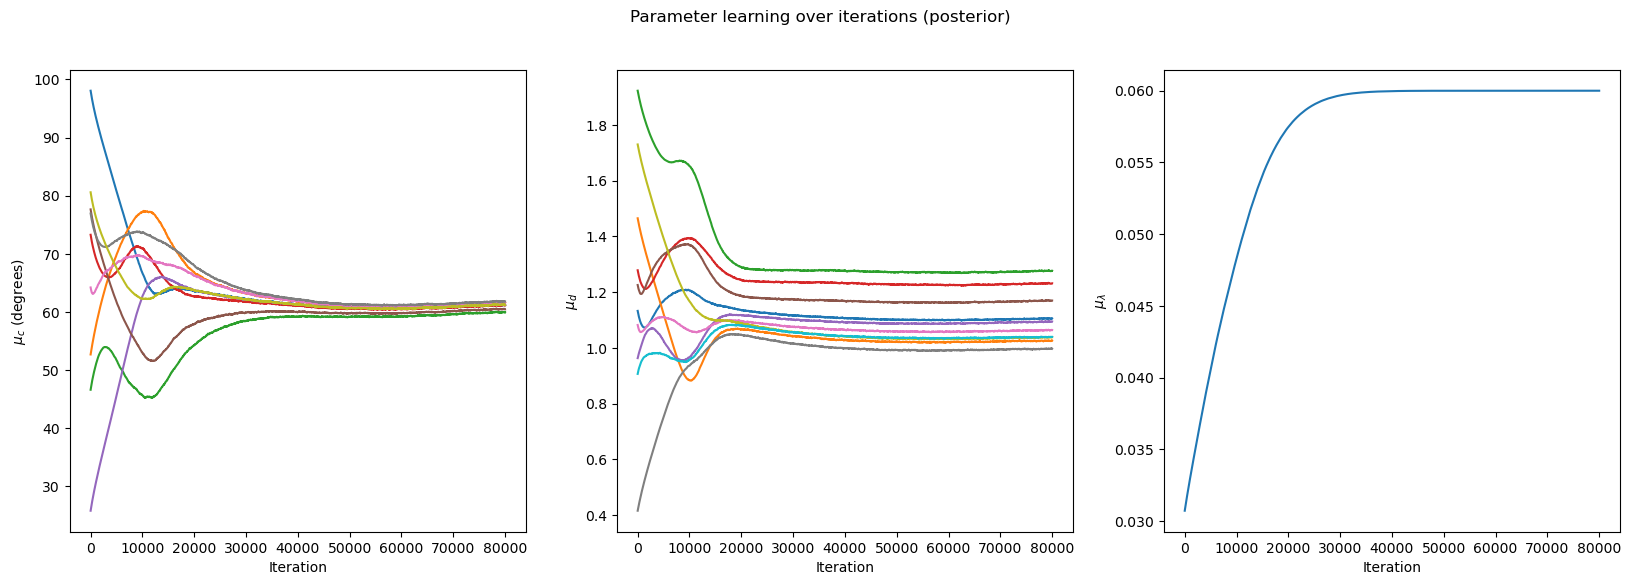

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post_null.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post_null.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post_null.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [23]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

Estimated global curvature: 61.117645263671875 degrees
Average estimated local curvature: 61.11891031068904 degrees


### Run optimization on real data

In [12]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 360.9734749533236
Loss updated
Iteration 1 | Loss: 360.9734749533236
Current loss: 336.99142982438207
Loss updated
Iteration 2 | Loss: 336.99142982438207
Current loss: 325.2839800193906
Loss updated
Iteration 3 | Loss: 325.2839800193906
Current loss: 361.9242550432682
Iteration 4 | Loss: 361.9242550432682
Current loss: 358.4960641860962
Iteration 5 | Loss: 358.4960641860962
Current loss: 333.5712036602199
Iteration 6 | Loss: 333.5712036602199
Current loss: 339.4084362350404
Iteration 7 | Loss: 339.4084362350404
Current loss: 349.3234437331557
Iteration 8 | Loss: 349.3234437331557
Current loss: 385.00756035000086
Iteration 9 | Loss: 385.00756035000086
Current loss: 352.8881251588464
Iteration 10 | Loss: 352.8881251588464
Epoch: 0, Loss: 4711.252496074281
Epoch: 250, Loss: 2197.323229909112
Epoch: 500, Loss: 1577.4604442472066
Epoch: 750, Loss: 1273.7216726797305
Epoch: 1000, Loss: 1088.6721835008286
Epoch: 1250,

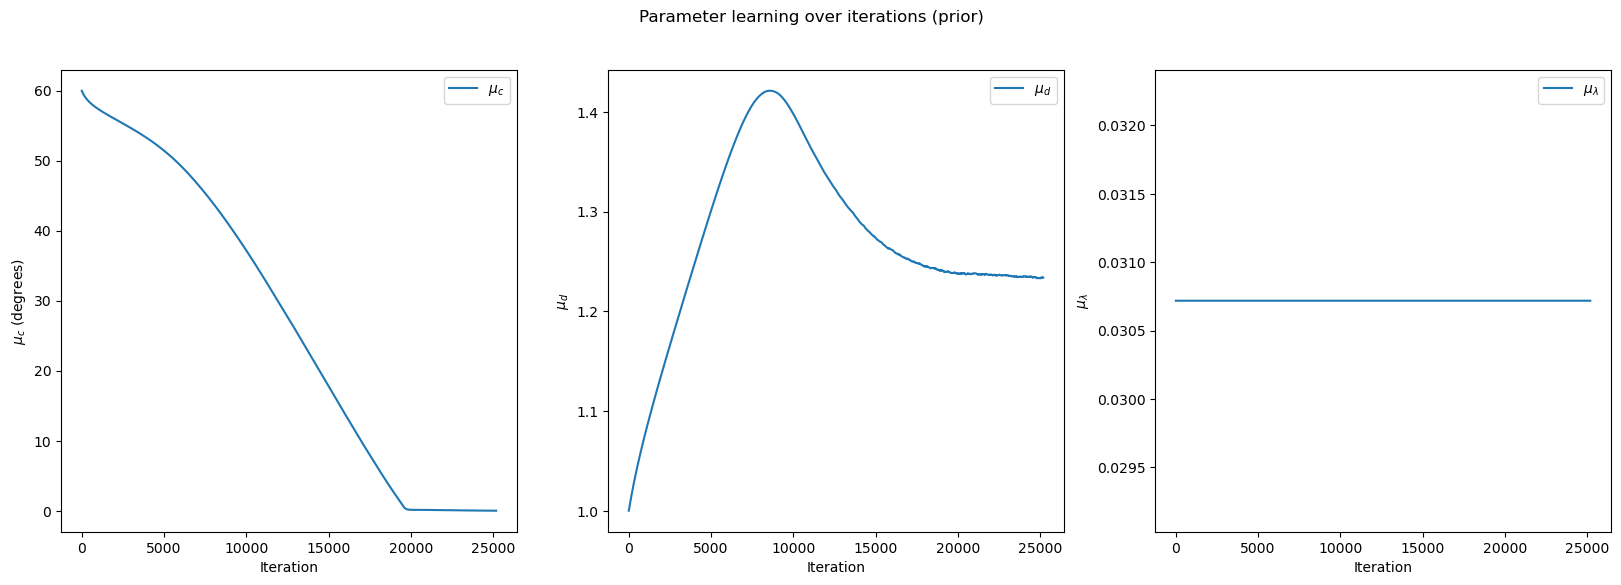

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

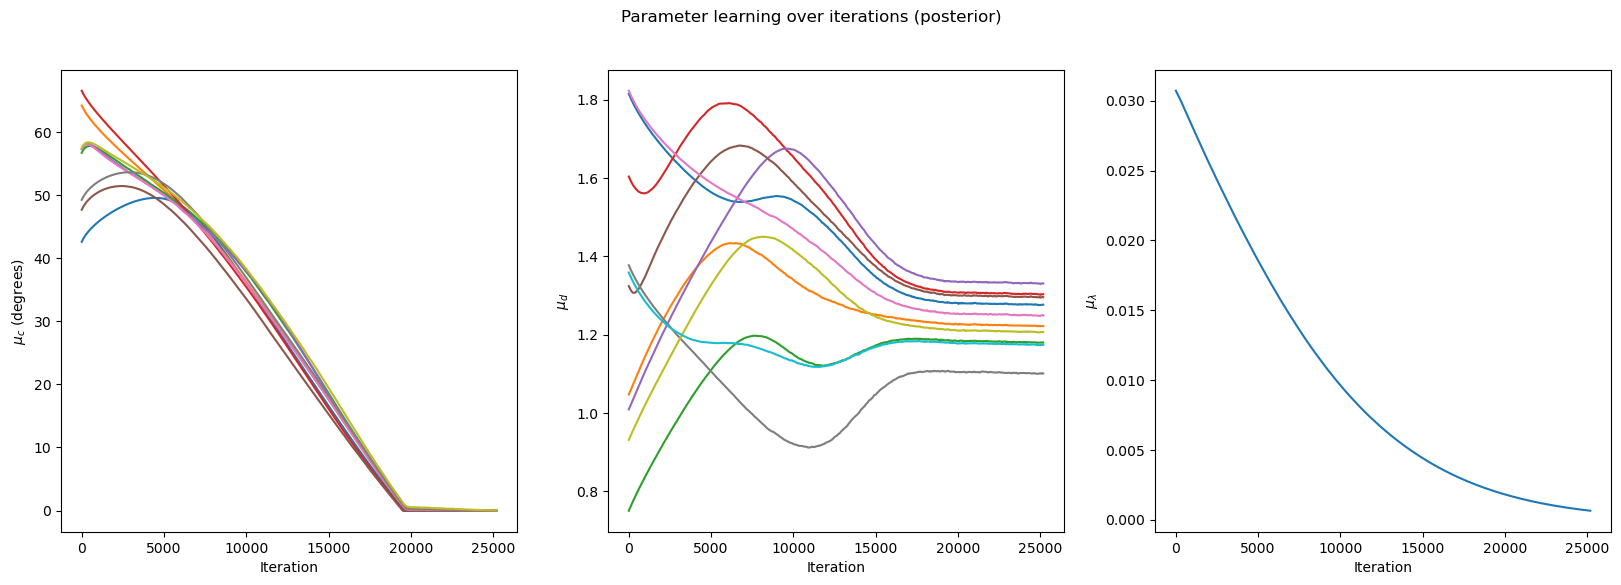

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [15]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 0.0050238934345543385 degrees
Average estimated local curvature: -0.01217300346268352 degrees


### Analyze results

In [16]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

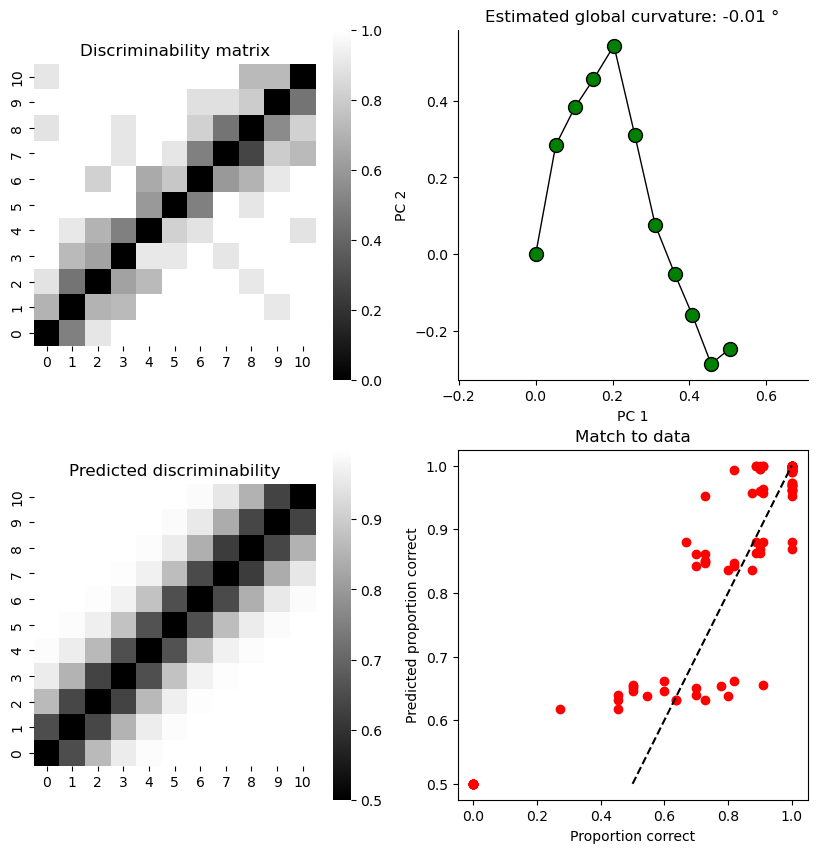

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()